In [481]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.ensemble import RandomForestClassifier


In [482]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)


In [483]:
# import the shots dataset
shots = pd.read_csv("../datasets/23_24_shotmaps.csv", index_col='Unnamed: 0')

shots = shots.fillna(0)


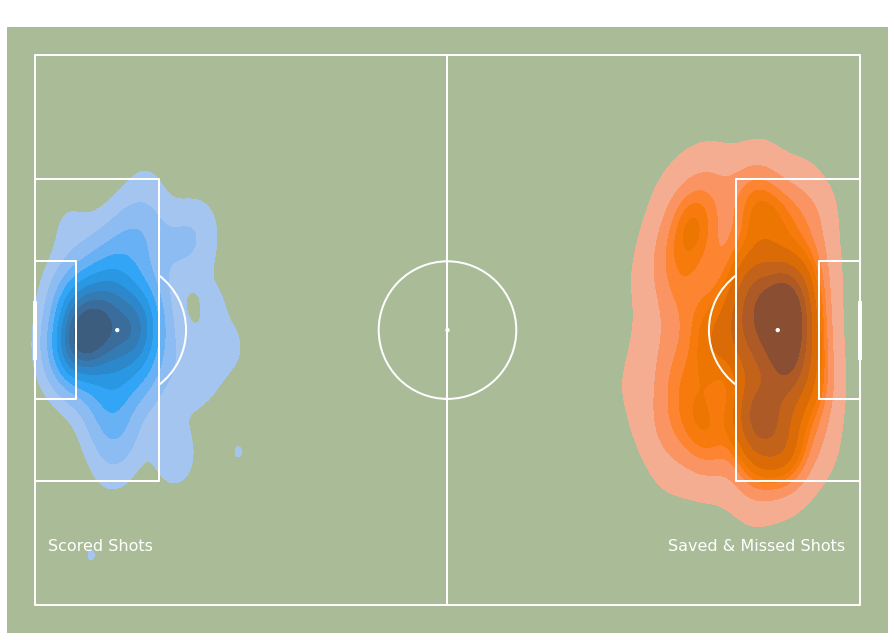

In [484]:
# create a split view plot
pitch = Pitch(
    pitch_color="#aabb97",
    line_color="white",
    stripe=False,
)

fig, ax = pitch.draw(figsize=(16, 9))

sns.kdeplot(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.x'] + 2.5,
    y=90 - shots[shots["outcome_goal"] == 1]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="Goal",
)

sns.kdeplot(
    x=117.5 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    y=90 - shots[shots["outcome_goal"] == 0]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="No Goal",
)

ax.annotate("Scored Shots", xy=(2, 72), c="White", fontsize=16)
ax.annotate("Saved & Missed Shots", xy=(92, 72), c="White", fontsize=16)

plt.title("Shotmap from Premier League Games 2023-2024 Season", c="White", fontsize=20)

plt.savefig("../assets/shotmap.png")
plt.show()

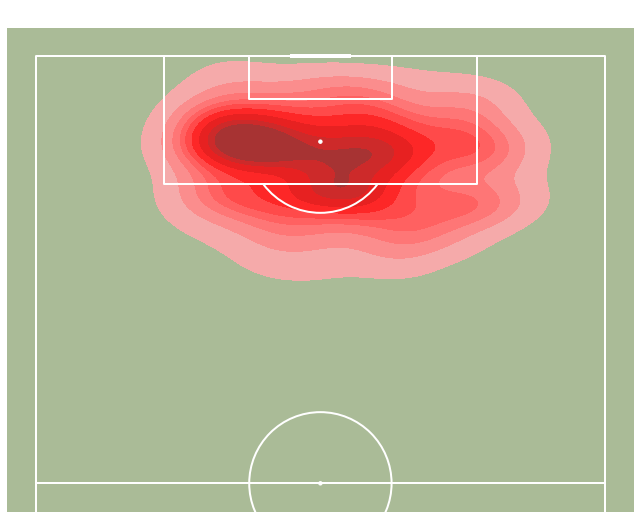

In [485]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, 
    pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

sns.kdeplot(
    x=shots[shots["outcome_block"] == 1]['playerCoordinates.y'] - 6.4,
    y=120 - shots[shots["outcome_block"] == 1]['playerCoordinates.x'],
    fill=True,
    zorder=-1,
    color='red'
)

plt.title("Density of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

In [509]:
span = shots[shots["outcome_miss"] == 0]['goalMouthCoordinates.y'].values
goal_mouth_y_span = min(span), max(span)

player_x_span = shots['playerCoordinates.x'].values
player_y_span = shots['playerCoordinates.y'].values

print('Goalmouth span:', *goal_mouth_y_span)
print('Player x span:',  min(player_x_span), max(player_x_span))
print('Player y span:', min(player_y_span), max(player_y_span))

Goalmouth span: 44.3 55.5
Player x span: 0.8 53.0
Player y span: 6.4 80.0


## Feature Engineneering

In [488]:
# calculate angle between ball and goal mouth
left_post = np.array([0, 44.3])
right_post = np.array([0, 55.5])

def distance_to_posts(shot_location:np.array, left_post:np.array, right_post:np.array):
    """
    Calculate the distances from a shot location to the left and right goal posts.

    Parameters:
    - shot_location (numpy.ndarray): An array containing the (x, y) coordinates of the shot location.
    - left_post (numpy.ndarray): An array containing the (x, y) coordinates of the left goal post.
    - right_post (numpy.ndarray): An array containing the (x, y) coordinates of the right goal post.

    Returns:
    - tuple: A tuple containing the distances to the left post, right post, and the distance between the posts.

    This function calculates the Euclidean distances from a shot location to the left and right goal posts
    and also computes the distance between the left and right goal posts.

    Example usage:
    distance_to_posts(np.array([10.0, 50.0]), np.array([0.0, 44.3]), np.array([0.0, 55.5]))
    """
    distance_to_left_post = np.sqrt(np.square(shot_location[:,0] - left_post[0]) + np.square(shot_location[:,1] - left_post[1]))
    distance_to_right_post = np.sqrt(np.square(shot_location[:,0] - right_post[0]) + np.square(shot_location[:,1] - right_post[1]))
    distance_between_posts = np.sqrt(np.square(right_post[1] - left_post[1]))

    return distance_to_left_post, distance_to_right_post, distance_between_posts

def goalmouth_angle(shot_location:np.array, left_post:np.array, right_post:np.array, degrees=False):
    """
    Calculate the angle between the shot location and the left and right goal posts.

    Parameters:
    - shot_location (numpy.ndarray): An array containing the (x, y) coordinates of the shot location.
    - left_post (numpy.ndarray): An array containing the (x, y) coordinates of the left goal post.
    - right_post (numpy.ndarray): An array containing the (x, y) coordinates of the right goal post.
    - degrees (bool, optional): If True, the angle is returned in degrees; if False (default), it's in radians.

    Returns:
    - float: The angle between the shot location and the goal posts.

    This function calculates the angle between the shot location and the left and right goal posts
    using the law of cosines.

    Example usage:
    goalmouth_angle(np.array([10.0, 50.0]), np.array([0.0, 44.3]), np.array([0.0, 55.5]))
    """
    a, b, c = distance_to_posts(shot_location, left_post, right_post)
    num = np.square(a) + np.square(b) - np.square(c)
    denom = 2 * a * b

    theta = np.arccos(num / denom)

    if degrees:
        theta *= 180 / np.pi

    return theta

In [489]:
shot_locations = shots[['playerCoordinates.x', 'playerCoordinates.y']].values
shots['shot.angle'] = goalmouth_angle(shot_locations, left_post, right_post, degrees=True)
shots['shot.distance'] = np.average(distance_to_posts(shot_locations, left_post, right_post)[:-1])

In [490]:
y = shots.outcome_goal
X = shots[
    [
        "playerCoordinates.x",
        "playerCoordinates.y",
        "playerCoordinates.z",
        "goalMouthCoordinates.x",
        "goalMouthCoordinates.y",
        "goalMouthCoordinates.z",
        "shot_sit_assisted",
        "shot_sit_corner",
        "shot_sit_free-kick",
        "shot_sit_set-piece",
        "bodyPart_left-foot",
        "bodyPart_right-foot",
        "shot.angle",
    ]
]

## Model Architecture & Compiling

In [491]:
tf.random.set_seed(111)

In [492]:
# split the data
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [493]:
xg_model = keras.Sequential()

xg_model.add(layers.Input(shape=X_train.shape[1]))

xg_model.add(layers.Dense(8, activation="tanh", input_shape=(X_train.shape,)))
xg_model.add(layers.Dense(16, activation="tanh"))
xg_model.add(layers.Dense(32, activation="tanh"))
xg_model.add(layers.Dropout(0.2))
xg_model.add(layers.Dense(64, activation="tanh"))

xg_model.add(layers.Dense(1, activation="sigmoid"))

In [494]:
xg_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 8)                 112       
                                                                 
 dense_46 (Dense)            (None, 16)                144       
                                                                 
 dense_47 (Dense)            (None, 32)                544       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 64)                2112      
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,977
Trainable params: 2,977
Non-traina

In [495]:
xg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=15,
    mode="min",
    monitor="val_loss",
    restore_best_weights=True,
)
# story history
xg_history = xg_model.fit(
    X_train, y_train, validation_split=0.2, callbacks=callback, epochs=200, verbose=1
)

Epoch 1/200
23/23 [==============================] - 1s 10ms/step - loss: 0.6406 - accuracy: 0.6145 - val_loss: 0.5347 - val_accuracy: 0.8500
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.8436 - val_loss: 0.3849 - val_accuracy: 0.9222
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3761 - accuracy: 0.8785 - val_loss: 0.2775 - val_accuracy: 0.9278
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3119 - accuracy: 0.8925 - val_loss: 0.2291 - val_accuracy: 0.9222
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.8994 - val_loss: 0.2163 - val_accuracy: 0.9167
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2945 - accuracy: 0.8980 - val_loss: 0.2105 - val_accuracy: 0.9278
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8994 - val_loss: 0.2123 - val_accuracy: 0.9222
Epoch 8/200


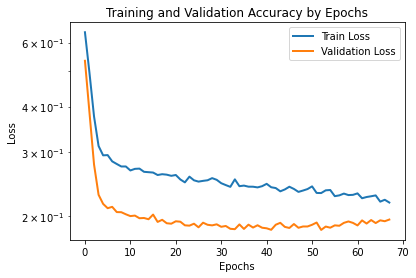

In [496]:
plt.title("Training and Validation Accuracy by Epochs")
plt.semilogy(xg_history.history["loss"], label="Train Loss", linewidth=2)
plt.semilogy(xg_history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Alternate models for comparision

In [497]:
results = {}
for depth in range(1, 20):
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)

    rf_pred_test = clf.predict_proba(X_test)[:,1]
    results[depth] = mean_squared_error(y_test, rf_pred_test)
    
optimal_depth = min(results, key=results.get)
print(f'Optimal depth is {optimal_depth}')

Optimal depth is 12


In [498]:
clf = RandomForestClassifier(max_depth=optimal_depth, random_state=0)
clf.fit(X_train, y_train)

rf_pred = clf.predict_proba(X_scaled)[:,1]
rf_pred_test = clf.predict_proba(X_test)[:,1]

## Generate xG Predictions

In [499]:
# predict on full data
ann_pred = xg_model.predict(X_scaled)
ann_pred_test = xg_model.predict(X_test)

In [500]:
ann_mse = mean_squared_error(y_test, ann_pred_test)
rf_mse = mean_squared_error(y_test, rf_pred_test)

print(f'ANN Model MSE: {ann_mse:0.4f}')
print(f'RF Model MSE: {rf_mse:0.4f}')

ANN Model MSE: 0.0870
RF Model MSE: 0.0737


In [501]:
if ann_mse == min(ann_mse, rf_mse):
    shots["xG"] = ann_pred
else:
    shots['xG'] = rf_pred

## Plot xG by Player Coordinates

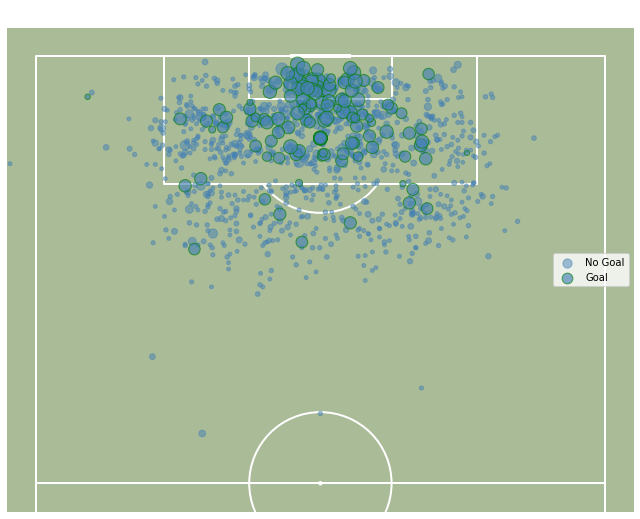

In [502]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_goal"] == 0]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    alpha=0.5,
    s=200 * shots[shots["outcome_goal"] == 0].xG + 15,
    c="steelblue",
    label="No Goal",
)

plt.scatter(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 1]['playerCoordinates.x'],
    alpha=0.65,
    s=200 * shots[shots["outcome_goal"] == 1].xG + 15,
    c="steelblue",
    edgecolor="green",
    label="Goal",
)

plt.title("Shotmap from Premier League Games '2023", c="White", fontsize=20)
plt.legend()

plt.savefig("../assets/xg_map.png")
plt.show()

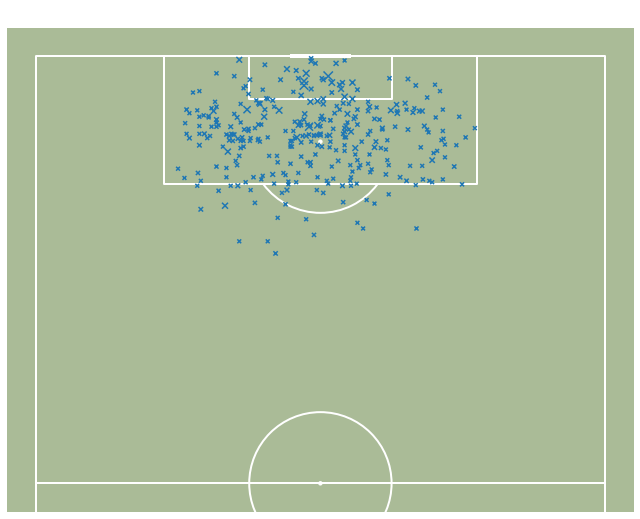

In [503]:
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True, pitch_length=105,
    pitch_width=68,
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_block"] == 1]['blockCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['blockCoordinates.x'],
    marker='x',
    s=200 * shots[shots["outcome_block"] == 1].xG + 15,
)

plt.title("Map of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

## Compile xG stats by player and team

In [504]:
xg_for = shots.groupby('team')['xG'].sum().sort_values(ascending=False)
xg_against = shots.groupby('opponent')['xG'].sum().sort_values(ascending=False)


xg_table = pd.concat([xg_for, xg_against], axis=1, keys=['xG', 'xGA'])
xg_table['xG_differential'] = xg_table['xG'] - xg_table['xGA']

In [505]:
xg_table = xg_table.sort_values(by='xG_differential', ascending=False)
xg_table['Team'] = xg_table.index
xg_table.reset_index(drop=True, inplace=True)
xg_table.index = range(1, xg_table.shape[0] + 1)

In [506]:
# sort columns alphabetically
desired_columns = sorted([col for col in xg_table.columns])

# Reorder the columns based on the desired order
xg_table = xg_table[desired_columns]
xg_table['xG'] = xg_table['xG'].map('{:,.2f}'.format)
xg_table['xGA'] = xg_table['xGA'].map('{:,.2f}'.format)
xg_table['xG_differential'] = xg_table['xG_differential'].map('{:,.2f}'.format)

xg_table = xg_table.rename(columns={'xG_differential': 'xG Differential'})

xg_table.to_markdown('../assets/xG_table.md', index=True)
xg_table.to_csv('../assets/xG_table.csv', index=True)
xg_table

,Team,xG,xGA,xG Differential
1,Manchester City,10.99,2.65,8.33
2,Tottenham Hotspur,10.53,4.53,5.99
3,Arsenal,8.35,3.24,5.11
4,Liverpool,8.59,4.70,3.89
5,Brighton & Hove Albion,10.03,6.52,3.51
6,West Ham United,8.59,5.21,3.38
7,Brentford,7.84,5.04,2.80
8,Crystal Palace,5.27,2.78,2.49
9,Newcastle United,7.09,5.90,1.19
10,Chelsea,5.97,4.88,1.09


### Player xG table

In [507]:
xg_by_player = pd.DataFrame(shots.groupby('player.name')['xG'].sum().sort_values(ascending=False))

player_team = shots[['player.name', 'player.position', 'team']].drop_duplicates(subset='player.name')

xg_by_player = xg_by_player.merge(player_team, how='left', left_on='player.name', right_on='player.name')
xg_by_player.reset_index(drop=True, inplace=True)
xg_by_player.index = range(1, len(xg_by_player) + 1)

xg_by_player = xg_by_player.rename(columns={'player.name': 'Player', 'player.position': 'Position', 'team': 'Team'})
xg_by_player = xg_by_player[['Player', 'Team', 'Position', 'xG']]
xg_by_player['xG'] = xg_by_player['xG'].map('{:,.2f}'.format)

xg_by_player.head(20).to_markdown('../assets/xG_by_player.md', index=True)
xg_by_player.head(20)

,Player,Team,Position,xG
1,Erling Haaland,Manchester City,F,5.34
2,Bryan Mbeumo,Brentford,F,3.34
3,Jarrod Bowen,West Ham United,M,3.23
4,Evan Ferguson,Brighton & Hove Albion,F,2.93
5,Taiwo Awoniyi,Nottingham Forest,F,2.68
6,Yoane Wissa,Brentford,F,2.51
7,Matty Cash,Aston Villa,D,2.44
8,Odsonne Édouard,Crystal Palace,F,2.35
9,Alexander Isak,Newcastle United,F,2.23
10,James Maddison,Tottenham Hotspur,M,2.19


In [508]:
shots.to_csv('../datasets/23_24_shotmaps_augmented.csv')